# House Price Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


**Step-1:** Import the dataset

In [2]:
df = pd.read_csv("/kaggle/input/housepricedataset/house_price_train.csv")
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Step-2:** Handling the Null values in the dataset

In [3]:
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [4]:
#Drop the null values if you have more than 30% of Null

df.dropna(axis=1, thresh=0.7*len(df), inplace=True)

#Fill the null values
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


**Step-3:** Splitting the Dataset

In [6]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [7]:
# Identify categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Apply One-Hot Encoding to all categorical columns
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X = X_encoded.copy()

**Step-4:** Applying Constant Feature

In [8]:
constant_feature = [col for col in X.columns if X[col].nunique == 1]
print(constant_feature)

[]


Step-5: Quasi Constant Feature

In [9]:
quasi_constant_feature = []
threshold = 0.99

for col in X.columns:
    freq = X[col].value_counts(normalize=True).iloc[0]
    if freq >= threshold:
        quasi_constant_feature.append(col)

print("quasi_constant_feature: ", quasi_constant_feature)

X = X.drop(columns=quasi_constant_feature, axis=1)

quasi_constant_feature:  ['PoolArea', 'Street_Pave', 'LotShape_IR3', 'Utilities_NoSeWa', 'LotConfig_FR3', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_NPkVill', 'Neighborhood_Veenker', 'Condition1_PosA', 'Condition1_RRAe', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Exterior2nd_ImStucc', 'Exterior2nd_Other', 'Exterior2nd_Stone', 'ExterQual_Fa', 'ExterCond_Po', 'Foundation_Stone', 'Foundation_Wood', 'BsmtCond_Po', 'BsmtFinType2_GLQ', 'Heating_Grav', 'Heating_

**Step-6:** Duplicate Features

In [10]:
train_T = X.T
duplicate_features = train_T[train_T.duplicated()].index.tolist()
print(duplicate_features)

X = X.drop(columns=duplicate_features, axis=1)

[]


**Step-7:** Correlation

In [11]:
corr_matrix = X.corr()
corr_threshold = 0.98
corr_pairs = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j] > corr_threshold):
            corr_pairs.add(corr_matrix.columns[i])

X = X.drop(columns=corr_pairs, axis=1)

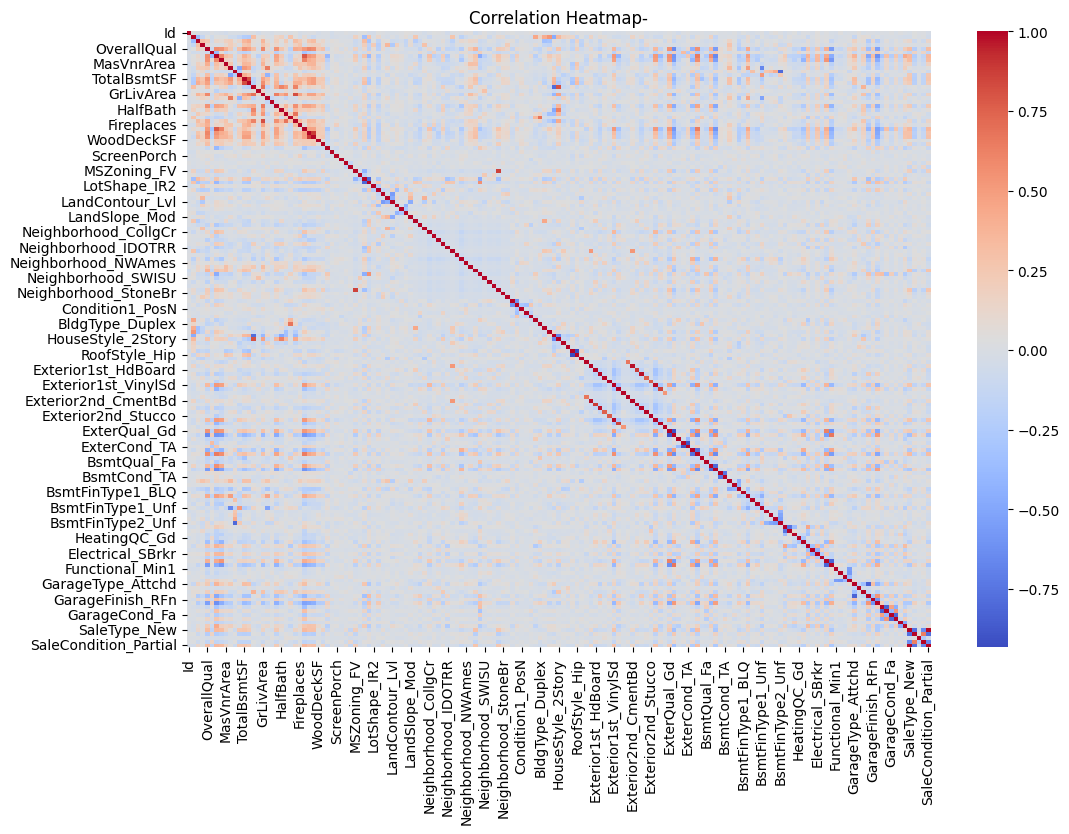

In [12]:
#Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap-")
plt.show()

**Step-8:** Mututal Information Regression

In [13]:
mi_scores = mutual_info_regression(X, y, discrete_features=False)
mi_df = pd.Series(mi_scores, index=X.columns)
mi_df = mi_df.sort_values(ascending=False)


low_importance = mi_df[mi_df < 0.01].index.tolist()

print(low_importance)

X = X.drop(columns=low_importance,axis=1)

['LandSlope_Mod', 'BsmtFinType2_LwQ', 'BsmtFinSF2', 'Condition1_Feedr', 'GarageQual_Fa', 'Exterior1st_WdShing', 'Functional_Typ', 'Foundation_Slab', 'LandContour_HLS', 'BldgType_2fmCon', 'Neighborhood_ClearCr', 'Condition1_Norm', 'Condition1_PosN', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Exterior1st_Plywood', 'Functional_Mod', 'Neighborhood_StoneBr', 'HouseStyle_1Story', 'Exterior1st_Stucco', 'HouseStyle_SFoyer', 'Neighborhood_Timber', 'Exterior2nd_Wd Shng', 'Functional_Min2', 'RoofMatl_CompShg', 'BsmtFinType2_Rec', 'ExterCond_TA', 'Condition1_RRAn', 'Exterior2nd_BrkFace', 'BsmtHalfBath', 'Condition2_Norm', 'BsmtExposure_Mn', 'GarageType_Basment', 'LandContour_Low', 'SaleCondition_Family', 'GarageCond_TA', 'PavedDrive_P', 'MiscVal', 'BsmtFinType2_BLQ', 'LotConfig_FR2', 'MoSold', 'BsmtFinType2_Unf', 'Heating_GasA', 'MSZoning_RH', 'YrSold', 'ExterCond_Gd', 'Heating_GasW', 'Exterior1st_BrkFace', 'BldgType_TwnhsE', 'Neighborhood_SWISU', '3SsnPorch', 'Functional_Min1', 'Id']


In [14]:
#Chi Square cannot be applied since the output feature is numerical

In [15]:
from sklearn.feature_selection import f_regression
import pandas as pd

f_scores, p_values = f_regression(X, y)

anova_df = pd.DataFrame({
    'F_Score': f_scores,
    'P_Value': p_values
}, index=X.columns)

anova_df = anova_df.sort_values(by='F_Score', ascending=False)

insignificant_features = anova_df[anova_df['P_Value'] > 0.05].index.tolist()

print("Dropping features with weak linear relationship:", insignificant_features)

X = X.drop(columns=insignificant_features)


Dropping features with weak linear relationship: ['Exterior2nd_Stucco', 'HouseStyle_SLvl', 'Neighborhood_Gilbert', 'LandContour_Lvl', 'LowQualFinSF', 'BsmtCond_TA', 'Neighborhood_NWAmes', 'Neighborhood_SawyerW']


In [16]:
# If y is a Series
df_final = X.copy()
df_final['target'] = y
df_final.to_csv('house_fs.csv', index=False)

print(df_final)

      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtUnf